In [4]:
import networkx as nx
import numpy as np
import configuration as conf
import itertools

#### custom node class

In [11]:
from faker import Faker
    
fake = Faker()
class Node:
    def __init__(self, id):
        curr_profile = fake.profile()
        self.types = {}
        self.id = id
        self.job = curr_profile['job']
        self.name = curr_profile['name']
        self.sex = curr_profile['sex']
        self.address = curr_profile['address']
        self.mail = curr_profile['mail']
        self.birthdate = curr_profile['birthdate']

    def add_connection(self, connected_to, type: str):
        try:
            assert type in conf.POSSIBLE_TYPES
        except AttributeError:
            raise AttributeError(f'Unidentified type was inserted: {type}')
        else:
            self.types[connected_to] = type

    def __str__(self):
        return str(self.id)

#### custom root class

In [12]:
class Root:
    def __init__(self, root_id: int, color: str, distribution_connections: dict):
        self.create_root(root_id)
        self.color = color
        self.how_many_each_type = {}
        self.distribution_connections = distribution_connections
        self.create_distribution_of_edge_types()

    def create_root(self, root_id):
        self.root = Node(root_id)

    def create_distribution_of_edge_types(self):
        for t, dis in self.distribution_connections.items():
            how_many = int(np.random.normal(dis[0], dis[1]))
            if how_many < 0:
                how_many = 0
            self.how_many_each_type[t] = how_many

    def __str__(self):
        return str(self.root)

#### custom graph class

In [13]:
class FullGraph:
    def __init__(self):
        self.current_id = 0
        self.full_graph = nx.Graph()
        self.color_map = []
        self.roots = []
        self.all_edge_nodes = []

    def create_root(self, color='Blue', distribution_connections=None):
        if distribution_connections is None:
            distribution_connections = {'Family': [5, 2], 'Friend': [5, 2], 'Other': [5, 5]}
        current_root = Root(self.current_id, color, distribution_connections)
        self.add_root_to_graph(current_root)
        self.add_to_colormap(current_root.color)
        self.add_root_to_list(current_root)
        self.update_id()

    def add_root_to_graph(self, root):
        self.full_graph.add_node(root)

    def add_to_colormap(self, color):
        self.color_map.append(color)

    def add_root_to_list(self, root):
        self.roots.append(root)

    def add_edges_to_each_root(self):
        for r in self.roots:
            for t, how_many in r.how_many_each_type.items():
                for i in range(how_many):
                    current_node = Node(self.current_id)
                    current_node.add_connection(connected_to=r.root.id, type=t)
                    self.full_graph.add_edge(r, current_node)
                    self.update_id()
                    self.add_to_colormap(conf.COLOR_MAPS[t])

    def connect_roots(self):
        for pair in itertools.combinations(self.roots, 2):
            con = np.random.choice(conf.TYPE_DIRECT_CONNECTIONS, p=conf.PROB_DIRECT_CONNECTIONS)
            if con:
                self.full_graph.add_edge(pair[0], pair[1])
                pair[0].root.add_connection(pair[1], con)
                pair[1].root.add_connection(pair[0], con)

    def update_id(self):
        self.current_id += 1

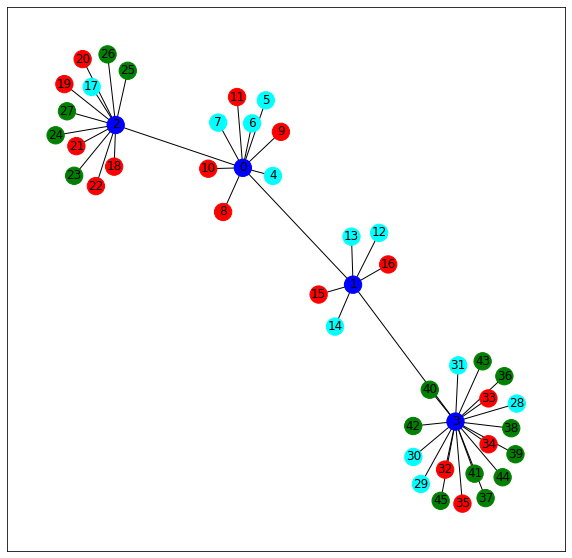

In [14]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    g = FullGraph()
    g.create_root('blue')
    g.create_root('blue')
    g.create_root('blue')
    g.create_root('blue')
    g.add_edges_to_each_root()
    g.connect_roots()


    plt.figure(figsize=(10, 10))
    nx.draw_networkx(g.full_graph, node_color=g.color_map)
    plt.show()

In [17]:
g.nodes()

AttributeError: 'FullGraph' object has no attribute 'nodes'